In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

$$ q_i = 1 / d $$
$$ \frac{p_i\prime}{q_i} = \frac{p_i}{q_i * (1 + \epsilon)} = \frac{p_i}{p_{max}} $$

In [2]:
import random


stats = np.loadtxt('us_births_69_88.csv', skiprows=1, delimiter=',', dtype=int)


def create_sample(counts):
    max_count = np.max(counts)
    size = counts.shape[0]
    
    def sample():
        day = random.randint(0, size - 1)
        if random.randint(1, max_count) <= counts[day]:
            return day
        return sample()
    return sample

def emp_dates(size, sample):
    s = set()
    for k in range(size + 1):
        day = sample()
        if day in s:
            return k + 1
        else:
            s.add(day)

15.5 s ± 468 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%%time

N = 100000
size = stats.shape[0]
sample = create_sample(stats[:, 2])
emp_sample = [emp_dates(size, sample) for iter in range(N)]

CPU times: user 15.4 s, sys: 11.6 ms, total: 15.5 s
Wall time: 15.5 s


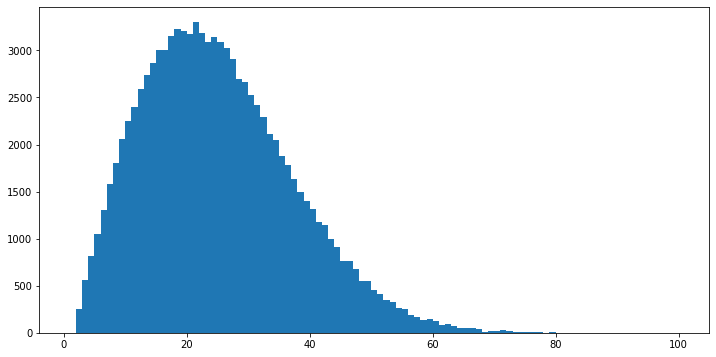

Couple first most likely values: [21 18 19 22 20 17 24 23 25 26]
Average value: 24.61854


In [4]:
plt.figure(figsize=(12, 6))
plt.hist(emp_sample, bins=range(1, 101))
plt.show()

vals, counts = np.unique(emp_sample, return_counts=True)
k_counts = vals[np.argsort(counts)][::-1]

print('Couple first most likely values: {}'.format(k_counts[:10]))
print('Average value: {}'.format(np.mean(emp_sample)))

**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays.
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

In [5]:
X = np.array([10,3,7])
I = np.array([1,1,2,2])
print(X[I])
X = np.array([[1,2],[3,4]])
I = np.array([0,0,1])
J = np.array([1,0,1])
print(X[I,J])

[3 3 7 7]
[2 1 4]


In [5]:
# vectorised version of sample() function
# instead of recursive call we do not return anything
def create_sample_vec(counts, sample_size):
    max_count = np.max(counts)
    size = counts.shape[0]
    
    sample_size = int(sample_size * 1.2) # just to be sure we create enough samples
    
    days = np.random.randint(0, size, sample_size)
    ok = np.random.randint(1, max_count + 1, sample_size) <= counts[days, 2]
    days = days[ok]
    return days

def emp_dates_vec(sample):
    dates = []
    s = set()
    k = 0
    for day in sample:
        k += 1
        if day in s:
            dates.append(k)
            k = 0
            s.clear()
        else:
            s.add(day)
    return dates

In [6]:
%%time

days = create_sample_vec(stats, N * 25) # average value of first repeats is lower than 25
emp_sample = emp_dates_vec(days)
print('Size of sample: {}'.format(len(emp_sample)))

Size of sample: 108524
CPU times: user 1.79 s, sys: 56.6 ms, total: 1.84 s
Wall time: 1.85 s


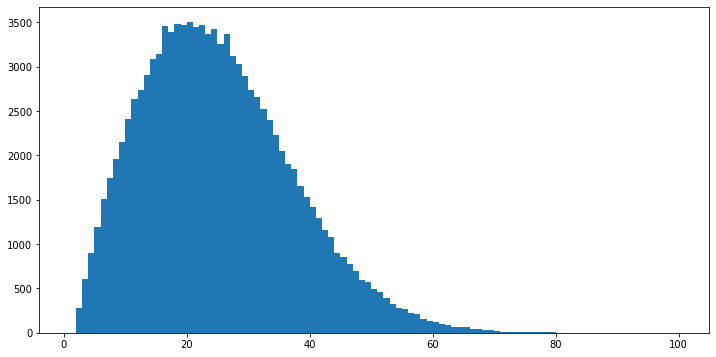

In [7]:
plt.figure(figsize=(12, 6))
plt.hist(emp_sample, bins=range(1, 101))
plt.show()

**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.


1. Algorithm always ends since each time we find bucket that overflows, there exists bucket that is not full. It is guaranteed - sum of probabilities equals 1. Each time, after such operation we have one more full bucket.
2. At the beginning each bucket contains exactly one piece of $p_i$. We don't modify buckets that are already full. Each time, when there are still not full buckets, we choose one of them, there must be exactly one piece. Also in buckets that overflow must be exactly one piece. So after filling the first bucket up it will then contain exactly two pieces and in future will not be modified. Still the rest of buckets not having exact volume contain exactly one piece.

This approach enables us to sample in $O(1)$. In general, each $p_i$ is maintained, but they may be part of maximally two buckets. All we have to do is choose a bucket and then for this bucket sample from $[0, 1]$, determining which $p_i$ piece we are to choose (of course if there is only one, choice is rather awkward). These way we make exactly 2 operations to sample a day what is significant improvement (in comparison to 1.c) - it is deterministically defined.

In [73]:
import queue

stats = np.loadtxt('us_births_69_88.csv', skiprows=1, delimiter=',', dtype=int)

size = stats.shape[0]
stats = np.transpose(stats)
counts_sum = np.sum(stats[2])

# Initializing bucket array in such way to avoid division by size
bucket = np.zeros((2, size))
bucket[0] = stats[2] * size

In [74]:
def equalise(bucket):
    over = queue.Queue()
    under = queue.Queue()

    def check_volume(vol, id):
        if vol > counts_sum:
            over.put(id)
        elif vol < counts_sum:
            under.put(id)
    
    for i in range(size):
        check_volume(bucket[0][i], i)
        
    while not (over.empty()):
        to_spill = over.get()
        to_fill = under.get()
        bucket[0][to_spill] = bucket[0][to_spill] - counts_sum + bucket[0][to_fill]
        bucket[1][to_fill] = to_spill
        check_volume(bucket[0][to_spill], to_spill)
        
    return bucket

In [75]:
def sample(bucket):
    id = random.randint(0, size - 1)
    if random.randint(1, counts_sum) <= bucket[0][id]:
        return id + 1
    return bucket[1][id] + 1

def dates(bucket):
    s = set()
    for k in range(size + 1):
        day = sample(bucket)
        if day in s:
            return k + 1
        else:
            s.add(day)

In [78]:
N = 100000

bucket = equalise(bucket)
bucket_sample = [dates(bucket) for iter in range(N)]

17.1 s ± 445 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


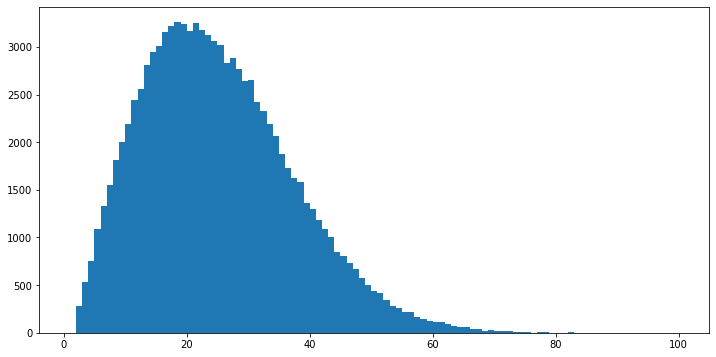

Couple first most likely values: [18 21 19 17 22 20 16 23 24 25]
Average value: 24.57993


In [79]:
plt.figure(figsize=(12, 6))
plt.hist(bucket_sample, bins=range(1, 101))
plt.show()

vals, counts = np.unique(bucket_sample, return_counts=True)
k_counts = vals[np.argsort(counts)][::-1]

print('Couple first most likely values: {}'.format(k_counts[:10]))
print('Average value: {}'.format(np.mean(bucket_sample)))


**Problem 2d.** Show that the frequency histogram for empirical birthday frequencies can actually be computed exactly, and implement your idea. To this end, design a recurence relation using conditional probabilities and use dynamic programming.

**BONUS**. An alternative plotting library: plotly